In [1]:
from math import floor, exp, sqrt, pi
import cmath
import numpy
from numpy import e, cos, zeros, arange, roll, where, random, ones, mean, reshape, dot, array, flipud, pi, exp, dot, angle, degrees, shape, linspace
import matplotlib.pyplot as plt
from itertools import chain
import scipy
from scipy import special
import numpy as np 
import seaborn as sns
import time
from joblib import Parallel, delayed
import multiprocessing
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import scipy.signal
from scipy.optimize import curve_fit 

numcores = multiprocessing.cpu_count()-3
numcores

def decode_rE(rE, a_ini=0, a_fin=360, N=512):
    #Population vector for a given rE
    # return ( angle in radians, absolut angle in radians, abs angle in degrees )
    N=len(rE)
    Angles = np.linspace(a_ini, a_fin, N) 
    angles=np.radians(Angles)
    rE = np.reshape(rE, (1,N))
    R = numpy.sum(np.dot(rE,exp(1j*angles)))/numpy.sum(rE)
    
    angle_decoded = np.degrees(np.angle(R))
    if angle_decoded<0:
        angle_decoded = 360+angle_decoded
    
    return angle_decoded
    #Mat.append(  [angle(R), abs(angle(R)) , degrees(abs(angle(R)))]  )
    #return round( np.degrees(abs(np.angle(R))), 2)



def closest(lst, K):       
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))] 
      


def circ_dist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)


def most_frequent(List): 
    dict = {} 
    count, itm = 0, '' 
    for item in reversed(List): 
        dict[item] = dict.get(item, 0) + 1
        if dict[item] >= count : 
            count, itm = dict[item], item 
    return(itm) 


def Interference_effects(target, response, reference):
    #input list of target, list of responses and list of references
    #Error_interference; positive for attraction and negative for repulsion
    #######
    #Decimals to get
    decimals=2
    ####
    interferences=[]
    for i in range(0, len(target)):
        angle_err_abs=abs(target[i] - response[i])
        if circ_dist(np.array(response)[i], np.array(reference)[i])<=circ_dist(np.array(target)[i], np.array(reference)[i]):
            Err_interference=round( angle_err_abs, decimals) 
        else:
            Err_interference=round( -angle_err_abs, decimals)
        interferences.append(Err_interference)
    
    return interferences


def viz_polymonial(X, y, poly_reg, pol_reg):
    plt.figure()
    plt.scatter(X, y, color='red')
    plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='blue')
    plt.title('Fit Bump')
    plt.xlabel('Neuron')
    plt.ylabel('rate')
    plt.show(block=False)
    return



def model_I0E(center_angle, size_windows, N=512):
    inf, sup = np.radians(center_angle) - np.radians(size_windows/2), np.radians(center_angle) + np.radians(size_windows/2)
    new_I0E=[]
    theta = [float(range(0,N)[i])/N*2*pi for i in range(0,N)];
    for i in theta:
        if i < closest(theta, inf):
            new_I0E.append(0)
        elif i>= closest(theta, inf) and i <=closest(theta, sup):
            new_I0E.append(1)
        else:
            new_I0E.append(0)
    
    return np.reshape(np.array(new_I0E), (N,1))



In [74]:
def simulation_m_b(totalTime, targ_onset, dist_onset, presentation_period, separation, inhib_curr, 
               time_ex_input=10, tauE=60, tauI=10, tauf=7000, taud=80, I0E=1.3, I0I=0.4, U=0.4,
               GEE=0.016, GEI=0.015, GIE=0.012 , GII=0.007, sigE=0.06, sigI=0.04,
               kappa_E=100, kappa_I=1.5, k_inhib=0.07, kappa_stim=20,
               N=512, plot_connectivity=True, plot_dyniamic=True, plot_heatmap=True, plot_fit=True ):
    
    ###### temporal and spatial settings
    st_sim =time.time()
    dt=2;
    nsteps=int(floor(totalTime/dt));
    origin = pi;
    targ_offset = targ_onset + presentation_period;
    targon = floor(targ_onset/dt);
    targoff = floor(targ_offset/dt);
    
    dist_offset = dist_onset  + presentation_period;
    diston = floor(dist_onset/dt);
    distoff = floor(dist_offset/dt);
    stim_sep = pi/separation; #(13 attract, 9 solo 1, 5 repulsion, 2 nada)
    
    targ_dist_delay = dist_onset - targ_offset
    I0E_standard = I0E
    #I0E_open =  I0E_standard + 0.5
    I0E_close= I0E_standard -0.35
    if inhib_curr == True: 
        I0E = I0E_close    
    
    ###### Connectivitiess
    v_E=np.zeros((N));
    v_I=np.zeros((N));
    WE=np.zeros((N,N));
    WI=np.zeros((N,N));
    theta = [float(range(0,N)[i])/N*2*pi for i in range(0,N)];
    for i in range(0, N):
        v_E_new=[e**(kappa_E*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_E)) for f in range(0, len(theta))]    
        v_I_new=[e**(kappa_I*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_I)) + k_inhib for f in range(0, len(theta))] #0.18
        ###    
        vE_NEW=np.roll(v_E_new,i)
        vI_NEW=np.roll(v_I_new,i) #to roll
        ###    
        WE[:,i]=vE_NEW
        WI[:,i]=vI_NEW
    
    #
    # Plot of the connectivity profile
    if plot_connectivity ==True:
        plt.figure()
        plt.plot(WE[250, :], label='E')
        plt.plot(WI[250, :], label = 'I')
        plt.ylim(0,6)
        plt.gca().spines['right'].set_visible(False) #no right axis
        plt.gca().spines['top'].set_visible(False) #no  top axis
        plt.gca().get_xaxis().tick_bottom()
        plt.gca().get_yaxis().tick_left()
        plt.title('Connectivity WE & WI')
        plt.show(block=False)
        plt.figure()
        plt.plot(WE[250, :] - WI[250, :] , label='E-I')
        #plt.plot(WI[250, :], label = 'I')
        #plt.ylim(0,6)
        plt.gca().spines['right'].set_visible(False) #no right axis
        plt.gca().spines['top'].set_visible(False) #no  top axis
        plt.gca().get_xaxis().tick_bottom()
        plt.gca().get_yaxis().tick_left()
        plt.title('Effective onnectivity')
        plt.show(block=False)
    
    #topography_pattern  =  WE[250, :] + -1*(WI[250, :]) ##plot the topography of the connectivities
    #plt.plot(topography_pattern, 'k')
    #plt.show(block=False)
    
    ###### Stimuli
    target=np.zeros((N))
    distractor=np.zeros((N))
    for i in range(0, N):
        target[i]=e**(kappa_stim*cos(theta[i] + origin - stim_sep))  / (2*pi*scipy.special.i0(kappa_stim)) ## target at (origin + sep)
        distractor[i]=e**(kappa_stim*cos(theta[i] + origin + stim_sep)) / (2*pi*scipy.special.i0(kappa_stim)) ## distractor at (origin -sep)
    
    
    #
    target = target+ np.random.normal(0, 0.01, N)
    target=reshape(target, (N,1))
    distractor = distractor+ np.random.normal(0, 0.01, N)
    distractor=reshape(distractor, (N,1)) 
    
    #plt.plot(target) ##plot the target and distractor
    #plt.plot(distractor)
    #plt.show(block=False)
    
    ###### Model   
    rE=np.zeros((N,1));
    rI=np.zeros((N,1)); 
    u = np.ones((N,1))*U
    x = np.ones((N,1))
    RE=np.zeros((N,nsteps));
    RI=np.zeros((N,nsteps));
    p_u=np.ones((N,nsteps));
    p_x=np.ones((N,nsteps));
    
    f = lambda x : x*x*(x>0)*(x<1) + reshape(array([cmath.sqrt(4*x[i]-3) for i in range(0, len(x))]).real, (N,1)) * (x>=1)
    
    
    #quadrant_selectivity = ones((N,1))
    
    #### Different quadrant_selectivity options
    start_q_se = model_I0E( np.degrees(origin + stim_sep),90)
    f1 = np.where(start_q_se==0, I0E_close, start_q_se)
    quadrant_selectivity_open = np.where(f1==1, I0E_standard, f1)
    ##
    start_q_se = model_I0E( np.degrees(origin + stim_sep),90)
    f1 = np.where(start_q_se==0, I0E_close, start_q_se)
    quadrant_selectivity_close = np.where(f1==1, I0E_close, f1)    
    ###  
    quadrant_selectivity_standard = I0E_standard * ones((N,1))
    
    quadrant_selectivity = quadrant_selectivity_standard
    
    
    #quadrant_selectivity =  model_I0E( np.degrees(origin - stim_sep),90)
    ### diferential equations
    for i in range(0, nsteps):
        noiseE = sigE*random.randn(N,1);
        noiseI = sigI*random.randn(N,1);

        #differential equations for connectivity
        #IE= GEE*dot(WE, (rE*u*x)) - GIE*dot(WI,rI) + I0E* ones((N,1)); 
        IE= GEE*dot(WE, (rE*u*x)) - GIE*dot(WI,rI) + quadrant_selectivity;
        II= GEI*dot(WE,rE) +  (I0I-GII*mean(rI))*ones((N,1));

        if i>targon and i<targoff:
            IE=IE+target;
            II=II+target;

        if i>diston and i<distoff:
            IE=IE+distractor;
            II=II+distractor;
        
        if inhib_curr == True: ### order 2
            if i< targon:
                #I0E=I0E_close
                quadrant_selectivity = quadrant_selectivity_close
            ###
            ### General
            ###
            if i > targon and i < targoff:
                #I0E=I0E_open
                quadrant_selectivity = quadrant_selectivity_open

            if i > targoff:
                #I0E = I0E_standard
                quadrant_selectivity = quadrant_selectivity_open
            ####
        #####
        elif inhib_curr == False: ### order 1
            if i< targon:
                quadrant_selectivity = quadrant_selectivity_standard
            ### General
            ###
            if i > targon and i < targoff:
                #I0E=I0E_open
                quadrant_selectivity = quadrant_selectivity_open

            if i > targoff:
                #I0E = I0E_open
                quadrant_selectivity = quadrant_selectivity_open
            ####
        #####################################################
        #####################################################
        #rates of exit and inhib   
        rE = rE + (f(IE) - rE + noiseE)*dt/tauE;
        rI = rI + (f(II) - rI + noiseI)*dt/tauI;
        ### formulas for synaptic plasticity: paper mongillo 2008
        u = u + ((U - u) / tauf + U*(1-u)*rE/1000)*dt;
        x = x + ((1 - x)/taud - u*x*rE/1000)*dt;
        
        rEr=np.reshape(rE, N)
        rIr=np.reshape(rI, N)
        ur=np.reshape(u, N)
        xr=np.reshape(x, N)
        #append
        RE[:,i] = rEr;
        RI[:,i] = rIr;
        p_u[:,i] = ur;
        p_x[:,i] = xr;
    
    
    #### Interference
    interference = Interference_effects( [decode_rE(target)], [decode_rE(rE)], [decode_rE(distractor)])[0]
    p_targ = int((N * np.degrees(origin + stim_sep))/360)
    if plot_dyniamic==True:
        #### plot dynamics
        fig = plt.figure()
        fig.tight_layout()
        fig.set_size_inches(13, 4)
        fig.add_subplot(131)
        p_targ = int((N * np.degrees(origin + stim_sep))/360)
        plt.title('Synaptic dynamics for target')
        plt.plot(p_u[p_targ, :], 'b', label='prob. release')
        plt.plot(p_x[p_targ, :], 'r', label='pool vesicles')
        plt.xlabel('time (ms)')
        plt.legend()
        fig.add_subplot(132)
        p_dist= int((N * np.degrees(origin - stim_sep))/360)
        plt.title('Synaptic dynamics for distractor')
        plt.plot(p_u[p_dist, :], 'b', label='prob.y release')
        plt.plot(p_x[p_dist, :], 'r', label='pool vesicles')
        plt.xlabel('time (ms)')
        plt.legend()
        fig.add_subplot(133)
        plt.title('Rate dynamics')
        plt.plot(RE[p_targ, :], 'b', label='target')
        plt.plot(RE[p_dist, :], 'r', label='distractor')
        plt.xlabel('time (ms)')
        plt.ylabel('rate (Hz)')
        plt.legend()
        plt.show(block=False)
    #
    if plot_heatmap==True:
        #### plot heatmap
        p_dist= int((N * np.degrees(origin - stim_sep))/360)
        plt.figure(figsize=(9,6))
        sns.heatmap(RE, cmap='viridis')
        plt.title('BUMP activity')
        plt.ylabel('Angle')
        plt.xlabel('time')
        plt.plot([targon, nsteps], [p_targ, p_targ], '--b',) ## flipped, so it is p_target 
        plt.plot([diston, nsteps], [p_dist, p_dist], '--r',) ## flipped, so it is p_target 
        plt.yticks([])
        plt.xticks([])
        plt.yticks([N/8, 3*N/8, 5*N/8, 7*N/8 ] ,['45','135','225', '315'])
        plt.plot([targ_onset/2, targ_onset/2,], [0+20, N-20], 'k-', label='onset')
        plt.plot([targ_offset/2, targ_offset/2,], [0+20, N-20], 'k--', label='offset')
        plt.plot([dist_onset/2, dist_onset/2,], [0+20, N-20], 'k-')
        plt.plot([dist_offset/2, dist_offset/2,], [0+20, N-20], 'k--')
        plt.legend()
        plt.show(block=False)
    
    
    ## print time consumed
    end_sim =time.time()
    total_time= end_sim - st_sim 
    total_time = round(total_time, 1)
    print('Simulation time: ' + str(total_time) + 's')
    
    #### Fit
    ###### Fit
    def von_misses(x,mu,k):
        return (exp( k * cos(x-mu))) / (2*pi*scipy.special.i0(k)) 

    def bi_von_misses(x,mu1,k1,mu2,k2):
        return von_misses(x,mu1,k1) + von_misses(x,mu2,k2)

    ##
    y=np.reshape(rE, (N)) 
    X=np.reshape(np.linspace(-pi, pi, N), N)

    ### Fit
    df_n_p=pd.DataFrame()
    df_n_p['rE'] = rE.reshape(512)
    peaks_list=[]
    for n_w_s in range(1, 100):
        r = df_n_p['rE'].rolling(window=n_w_s).mean()
        number_of_bumps = len(scipy.signal.find_peaks(r, 2)[0]) 
        peaks_list.append(number_of_bumps)
    #
    if number_of_bumps == 0:
        if peaks_list==[0 for i in range(len(peaks_list))]:
            number_of_bumps = 0
        else:
            peaks_list[:] = (value for value in peaks_list if value != 0)
            number_of_bumps=most_frequent(peaks_list)
    #
    number_of_bumps=most_frequent(peaks_list)
    #print(number_of_bumps)
    #number_of_bumps = 2
    ### Fit
    ### Fit
    if number_of_bumps ==2:
        target_pos_pi_pi = decode_rE(target) * 2*pi / 360 -pi
        distractor_pos_pi_pi = decode_rE(distractor) * 2*pi / 360 -pi
        param, covs = curve_fit(bi_von_misses, X, y, p0=[target_pos_pi_pi + pi, -36,  distractor_pos_pi_pi - pi, -36]) #p0=[separation, 75, -separation, 75]
        ans = (exp( param[1] * cos(X-param[0]))) / (2*pi*scipy.special.i0(param[1])) + (exp( param[3] * cos(X-param[2]))) / (2*pi*scipy.special.i0(param[3])) 
        estimated_angles=[]
        for p in [param[0], param[2]]:
            estim_ang = np.degrees(p)
            if estim_ang<0:
                estim_ang = 360+estim_ang
            estimated_angles.append(estim_ang)
        
        #
        #print(estimated_angles)
        #decoded angles
        decoded_target = closest(estimated_angles, decode_rE(target))
        decoded_distractor = closest(estimated_angles, decode_rE(distractor))
        #bias
        bias_target = Interference_effects(  [decode_rE(target)],  [decoded_target],  [decode_rE(distractor)])[0]
        bias_dist = Interference_effects(  [decode_rE(distractor)],  [decoded_distractor],  [decode_rE(target)])[0]
        final_bias = [bias_target, bias_dist]
        skip_r_sq=False
        success=True
        #print(np.degrees( origin - pi/separation), decode_rE(target))
        #print(np.degrees( origin + pi/separation), decode_rE(distractor))
        #print(targ_ang, dist_ang)


    elif number_of_bumps ==1:
        param, covs = curve_fit(von_misses, X, y)
        ans = (exp( param[1] * cos(X-param[0]))) / (2*pi*scipy.special.i0(param[1])) 
        estimated_angle_1=np.degrees(param[0]+pi)
        estimated_angle_2=np.degrees(param[0]+pi)
        estimated_angle=np.degrees(param[0]+pi)  
        
        min_bias = min(  abs(estimated_angle - np.degrees( origin + pi/separation)), 
                       abs(estimated_angle - np.degrees( origin - pi/separation))  )
        if min_bias == abs(estimated_angle - np.degrees( origin + pi/separation)):
            bias_b1 = estimated_angle - np.degrees( origin + pi/separation)
            bias_b2 = estimated_angle - np.degrees( origin - pi/separation)
        else:
            bias_b1 = estimated_angle - np.degrees( origin - pi/separation)
            bias_b2 = estimated_angle - np.degrees( origin + pi/separation)
        ##
        #bias_b1 = estimated_angle - np.degrees( origin - pi/separation)
        #bias_b2 = np.degrees(origin + pi/separation) - estimated_angle  ## bias (positive means attraction)
        final_bias = [bias_b1, bias_b2]  
        skip_r_sq=False
        success=True

    else:
        print('Error simultaion')
        final_bias=[999, 999]
        plot_fit=False
        skip_r_sq=True
        r_squared=0
        success=False ## to eliminate wrong simulations easily at the end

    #error_fit (r_squared)
    if skip_r_sq==False:
        residuals = y - ans
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-numpy.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)

    #plot fit
    if plot_fit==True:
        plt.figure()
        plt.plot(X, y, 'o', color ='red', label ="data") 
        plt.plot(X, ans, '--', color ='blue', label ="fit") 
        plt.legend() 
        plt.show(block=False) 
    
    ### Output
    #return RE,  RI, p_u, p_x
    #return interference, targ_dist_delay 
    max_re = max(rE)[0]
    ### interfernce max
    #dec_far = np.linspace(180,0,int(N/2))[np.where(y[int(N/2):]==max(y[int(N/2):]))[0][0]]
    #dec_close = np.linspace(180,0,int(N/2))[np.where(y1[int(N/2):]==max(y1[int(N/2):]))[0][0]]
    #int_close = dec_close - np.degrees( pi - pi/4)
    #int_far = dec_far - np.degrees( pi - pi/4)
    angle_separation = round(2*np.degrees(pi/separation),2)
    
    return bias_target, bias_dist, number_of_bumps, angle_separation #rE[p_targ][0], I0E

Examples of all conditions

In [ ]:
### 1_02 (far)

bias_target, bias_dist, number_of_bumps, angle_separation  = simulation_m_b(totalTime=6200, 
                                                          targ_onset = 200,
                                                          dist_onset=1000, 
                                                          presentation_period=250,
                                                          separation=16, 
                                                          inhib_curr=False, 
                                                          time_ex_input=0, 
                                                          sigE=0.7,
                                                          GEE=0.016,
                                                          plot_connectivity=False, 
                                                          plot_dyniamic=True, 
                                                          plot_heatmap=True, 
                                                          plot_fit=True )
print(bias_target, bias_dist, angle_separation)

In [ ]:
### 1_7 far
bias_target, bias_dist, number_of_bumps, angle_separation  = simulation_m_b(totalTime=6200, 
                                                          targ_onset = 200,
                                                          dist_onset=3900, 
                                                          presentation_period=250,
                                                          separation=16, 
                                                          inhib_curr=False, 
                                                          time_ex_input=0, 
                                                          sigE=0.7,
                                                          GEE=0.016,
                                                          plot_connectivity=False, 
                                                          plot_dyniamic=True, 
                                                          plot_heatmap=True, 
                                                          plot_fit=True )
print(bias_target, bias_dist, angle_separation)

In [ ]:
### 2_02 far
bias_target, bias_dist, number_of_bumps, angle_separation  = simulation_m_b(totalTime=6200,
                                                          targ_onset = 550,
                                                          dist_onset=200, 
                                                          presentation_period=250,
                                                          separation=16, 
                                                          inhib_curr=True, 
                                                          time_ex_input=0, 
                                                          sigE=0.7, 
                                                          plot_connectivity=False, 
                                                          plot_dyniamic=True, 
                                                          plot_heatmap=True, 
                                                          plot_fit=True )
print(bias_target, bias_dist, angle_separation)

In [ ]:
### 2_7 (far)

bias_target, bias_dist, number_of_bumps, angle_separation  = simulation_m_b(totalTime=9600,
                                                          targ_onset = 3950,
                                                          dist_onset=200, 
                                                          presentation_period=250,
                                                          separation=16, 
                                                          inhib_curr=True, 
                                                          time_ex_input=0, 
                                                          sigE=0.7, 
                                                          plot_connectivity=False, 
                                                          plot_dyniamic=True, 
                                                          plot_heatmap=True, 
                                                          plot_fit=True )
print(bias_target, bias_dist, angle_separation)

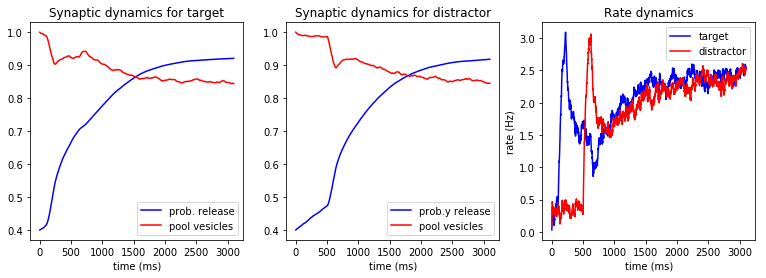

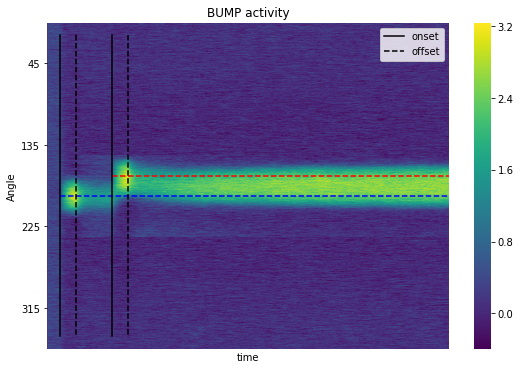

Simulation time: 36.5s


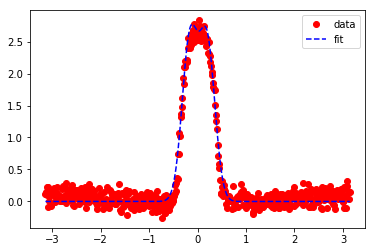

0.32 1.72 22.5


In [50]:
####

bias_target, bias_dist, number_of_bumps, angle_separation  = simulation_m_b(totalTime=6200, 
                                                          targ_onset = 200,
                                                          dist_onset=1000, 
                                                          presentation_period=250,
                                                          separation=16, 
                                                          inhib_curr=False, 
                                                          time_ex_input=0, 
                                                          sigE=0.7,
                                                          GEE=0.016,
                                                          plot_connectivity=False, 
                                                          plot_dyniamic=True, 
                                                          plot_heatmap=True, 
                                                          plot_fit=True )
print(bias_target, bias_dist, angle_separation)

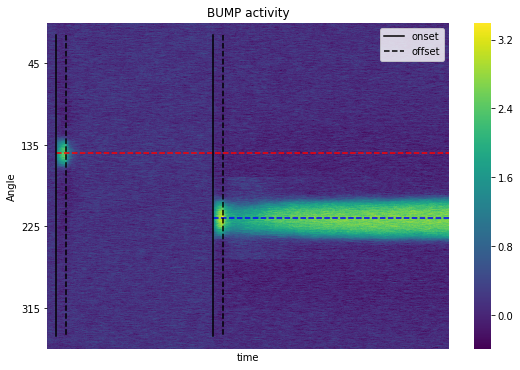

Simulation time: 53.1s


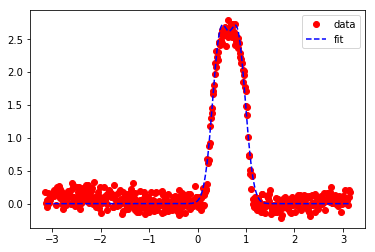

9.89 62.47 72.0


In [54]:
bias_target, bias_dist, number_of_bumps, angle_separation  = simulation_m_b(totalTime=9600,
                                                          targ_onset = 3950,
                                                          dist_onset=200, 
                                                          presentation_period=250,
                                                          separation=5, 
                                                          inhib_curr=True, 
                                                          time_ex_input=0, 
                                                          sigE=0.7, 
                                                          plot_connectivity=False, 
                                                          plot_dyniamic=False, 
                                                          plot_heatmap=True, 
                                                          plot_fit=True )
print(bias_target, bias_dist, angle_separation)

In [ ]:
bias_target, bias_dist, number_of_bumps, angle_separation  = simulation_m_b(totalTime=6200,
                                                          targ_onset = 550,
                                                          dist_onset=200, 
                                                          presentation_period=250,
                                                          separation=5, 
                                                          inhib_curr=True, 
                                                          time_ex_input=0, 
                                                          sigE=0.7, 
                                                          plot_connectivity=False, 
                                                          plot_dyniamic=False, 
                                                          plot_heatmap=True, 
                                                          plot_fit=True )
print(bias_target, bias_dist, angle_separation)

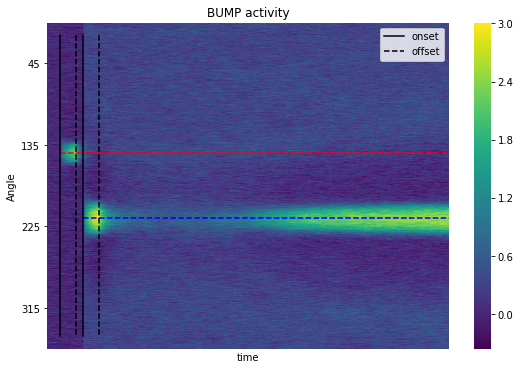

Simulation time: 66.6s


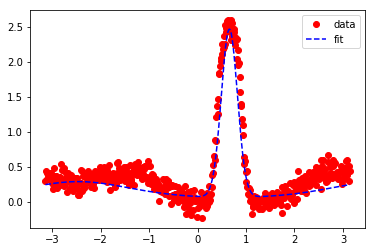

-1.2 73.4 72.0


In [28]:
bias_target, bias_dist, number_of_bumps, angle_separation  = simulation_m_b(totalTime=6200,
                                                          targ_onset = 550,
                                                          dist_onset=200, 
                                                          presentation_period=250,
                                                          separation=5, 
                                                          inhib_curr=True, 
                                                          time_ex_input=0, 
                                                          sigE=0.7, 
                                                          plot_connectivity=False, 
                                                          plot_dyniamic=False, 
                                                          plot_heatmap=True, 
                                                          plot_fit=True )
print(bias_target, bias_dist, angle_separation)

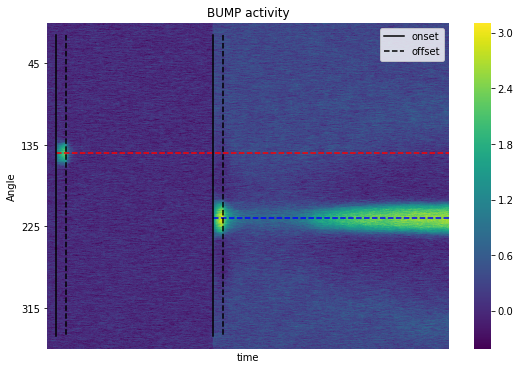

Simulation time: 100.7s


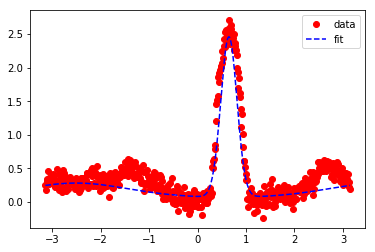

0.07 71.99 72.0


In [29]:
bias_target, bias_dist, number_of_bumps, angle_separation  = simulation_m_b(totalTime=9600,
                                                          targ_onset = 3950,
                                                          dist_onset=200, 
                                                          presentation_period=250,
                                                          separation=5, 
                                                          inhib_curr=True, 
                                                          time_ex_input=0, 
                                                          sigE=0.7, 
                                                          plot_connectivity=False, 
                                                          plot_dyniamic=False, 
                                                          plot_heatmap=True, 
                                                          plot_fit=True )
print(bias_target, bias_dist, angle_separation)

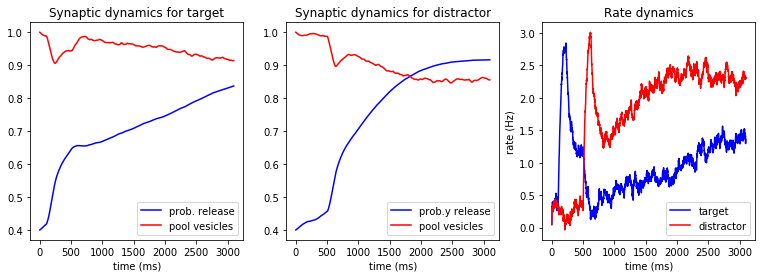

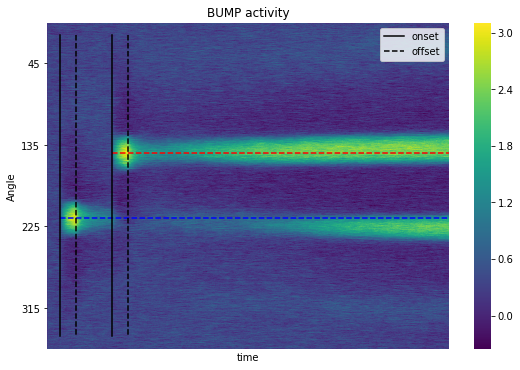

Simulation time: 69.0s


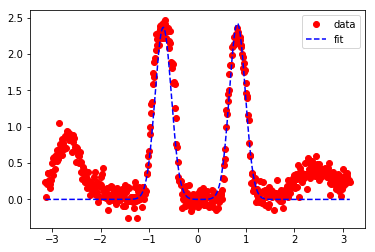

-10.73 -5.12 72.0


In [30]:
bias_target, bias_dist, number_of_bumps, angle_separation  = simulation_m_b(totalTime=6200, 
                                                          targ_onset = 200,
                                                          dist_onset=1000, 
                                                          presentation_period=250,
                                                          separation=5, 
                                                          inhib_curr=False, 
                                                          time_ex_input=0, 
                                                          sigE=0.7,
                                                          GEE=0.016,
                                                          plot_connectivity=False, 
                                                          plot_dyniamic=True, 
                                                          plot_heatmap=True, 
                                                          plot_fit=True )
print(bias_target, bias_dist, angle_separation)

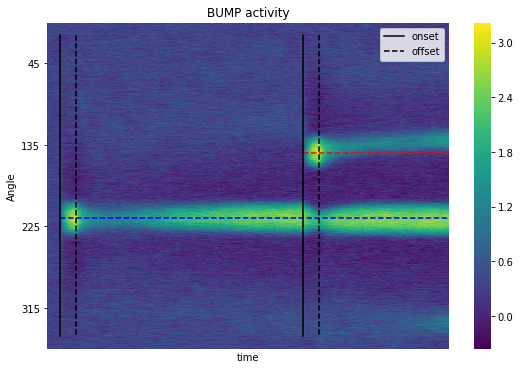

Simulation time: 65.3s


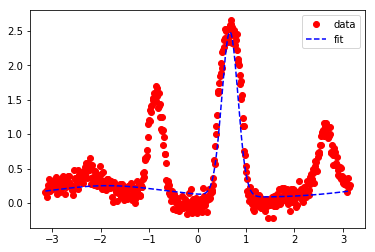

-1.67 -71.17 72.0


In [31]:
bias_target, bias_dist, number_of_bumps, angle_separation = simulation_m_b(totalTime=6200,
                                                          targ_onset = 200,
                                                          dist_onset=450+3500, 
                                                          presentation_period=250,
                                                          separation=5, 
                                                          inhib_curr=False, 
                                                          time_ex_input=0, 
                                                          sigE=0.7, 
                                                          plot_connectivity=False, 
                                                          plot_dyniamic=False, 
                                                          plot_heatmap=True, 
                                                          plot_fit=True )
print(bias_target, bias_dist, angle_separation)